# Identify working and data directory and site ID.
* The working directory is the root directory of the github.
* The data directory points to the google drive folder where the larger data files are stored.
* For the moment the site ID if the four-digit NEON site ID.

In [5]:
working<-"~/neon_suna"
site_id<-"COMO"
data<-paste("~/gdrive/SUNA_data/SUNA_NEON/",site_id,sep="")


# Initialize required libraries, functions and formatting utilities.

In [6]:
library(dplyr)
library(streamMetabolizer)
library(splitstackshape)
library(ggplot2)
library(lubridate)
library(reshape2)
library(neonUtilities)
library(progress)
library(patchwork)
library(doBy)
#library(box)

theme_ts_space<-theme_grey() +
		theme(
#		panel.grid.major = element_blank(),
#		panel.grid.minor = element_blank(),
		panel.background = element_rect(fill="white", colour="black", size=2),
#		legend.key       = element_blank(),
#		legend.text      = element_text(size=20.5),
#		legend.text      = element_blank(),
#		legend.title     = element_text(size=20.5),
		axis.text.x = element_text(size=22,colour="black",hjust=1,angle=45),
		axis.text.y = element_text(size=22,colour="black",vjust=.3),
		axis.title.x = element_text(size=22),
		axis.title.y = element_text(size=22,vjust=-1),
#		plot.title = element_text(hjust = 0.5,size=22,face="bold"),		
#		legend.position  = "left",
		legend.position  = "none",
		plot.margin = unit(c(1,1,1,1), "cm"),
		panel.border = element_rect(colour = "black", fill=NA, size=2)
		)





# Setting up the workspace
In the cell below indicate the site that will be analyzed here according to its NEON 4-letter code. A list of files for that site is then placed in the vector "sunas".

If you downloaded the repo into your home director, which is found by going to "~/", then you don"t have to change the box path. FYI: Box is a new package for R that allows you to define a set of functions without creating a new package.

In [7]:

#setwd(paste("~/gdrive/SUNA_data/SUNA_NEON/",site_id,sep=""))
#sunas<-list.files(pattern="*.csv")
#getwd()
#options(box.path = "~/neon_suna/box/")
#box::use(plots)

setwd(data)
sunas<-list.files(pattern="*.csv")


In [8]:
str(sunas)

 chr [1:2] "COMO_202000707.csv" "COMO_20200525.csv"


# Data import and processing loop.
This step loads each data file, formats the data for use, and concatenates files from an individual site.

This step could take a while.

[1] 1


In [19]:
options(warn=-1)
compiled_suna<-data.frame()
sunas_length<-length(sunas)
for(i in 1:sunas_length){
#pb$tick()	
print(i)

suna<-read.csv(paste(sunas[i]),skip=0,header=FALSE)

if(i==1){
suna_cal<-read.csv("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/COMO/CALS/SUNA_770_CAL_abbr.csv")
suna_cal_t<-as.data.frame(t(suna_cal))
names(suna_cal_t)<-suna_cal_t[1,]
}

if(i==2){
suna_cal<-read.csv("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/COMO/CALS/SUNA_770_2_CAL_abbr.csv")
suna_cal_t<-as.data.frame(t(suna_cal))
names(suna_cal_t)<-suna_cal_t[1,]
}


#suna_d0<-cSplit(suna,3, ",")
names(suna)<-c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","inter_time",suna_cal$wavelength_nm,"sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum")


suna<-subset(suna,a254!=0)
doy<-gsub("2020","",suna$date,fixed=TRUE)
day<-as.POSIXct(paste(as.Date(as.numeric(doy),origin="2020-01-01"),"00:00:00"),tz="UTC")
#suna$day<-as.POSIXct('2019-05-10 00:00:00',tz="UTC")
suna$dtp<-day + (3600*as.numeric(suna$time))
attr(suna$dtp,"tzone") <- "Etc/GMT+8"

offse<-c(t(suna_cal_t[3,]))
suna2<-(suna[,grep("^[0-9]{3}",names(suna))]/suna$inter_time)-suna$dark_signal_average
suna_d0_norm<-sweep(suna2,2,FUN="/",offse)
names(suna_d0_norm)<-paste("n_",names(suna_cal_t),sep="")





suna_d0_int<-data.frame()
for(j in 1:nrow(suna_d0_norm)){	
	flip<-as.data.frame(t(suna_d0_norm[j,]))
	names(flip)<-c("abs")
	flip$wl_nm<-gsub("n_","",row.names(flip),fixed=TRUE)
	flip_int<-as.data.frame(t(approx(flip$wl_nm,flip$abs,xout=seq(189,394,1),rule=2)$y))
	names(flip_int)<-paste("interp_",seq(189,394,1),sep="")
	suna_d0_int<-bind_rows(suna_d0_int,flip_int)
}
suna_d<-bind_cols(suna,suna_d0_int)
#suna_d$date<-as.character(suna_d[,c("date")])
#suna_d$time<-as.character(suna_d[,c("time")])
suna_d2<-suna_d %>% mutate_if(is.numeric,as.character)
compiled_suna<-bind_rows(compiled_suna,suna_d2)
}
print("done")
options(warn=0)    
    
    
    


[1] 1
[1] 2
[1] "done"


# Check Data and Save

In [23]:
#i
#grepl("D2020",sunas[240])
#sunas[240]
#length(sunas)
#sunas[240]
#ncol(compiled_suna)
#nrow(compiled_suna)
saveRDS(compiled_suna,"/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/COMO/SUNA_COMO_20210428_full.rds")
compiled_suna<-readRDS("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/COMO/SUNA_COMO_20210428_full.rds")


# Extracting the interpolated columns

In [26]:
suna_interp<-compiled_suna[,grepl("^interp",names(compiled_suna))] %>% mutate_if(is.character, ~as.numeric(.))

In [27]:


other_suna<-compiled_suna[,c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","inter_time","sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum","dtp")]



suna_cols<-bind_cols(other_suna,suna_interp)
suna_cols$a254<-as.numeric(suna_cols$a254)
suna_cols$a350<-as.numeric(suna_cols$a350)
suna_cols$nitrate<-as.numeric(suna_cols$nitrate)
suna_cols$nitrate_mgl<-as.numeric(suna_cols$nitrate_mgl)
suna_cols$sensor_temp<-as.numeric(suna_cols$sensor_temp)


In [33]:

a350_mod<-lm(a350~log10(interp_350)+I(log10(interp_350)^2)+I(log10(interp_350)^3),suna_cols)
a254_mod<-lm(a254~log10(interp_254)+I(log10(interp_254)^2)+I(log10(interp_254)^3),suna_cols)



cor_cols<-grep("^interp_",names(suna_cols))

names(suna_cols)

[1] "suna_id"             "date"                "time"               
  [4] "nitrate"             "nitrate_mgl"         "a254"               
  [7] "a350"                "bromide_trace"       "spec_average_dark"  
 [10] "dark_signal_average" "inter_time"          "sensor_temp"        
 [13] "spec_temp"           "lamp_temp"           "lamp_time"          
 [16] "rel_hum"             "main_volt"           "lamp_volt"          
 [19] "int_volt"            "main_current"        "fit_aux_1"          
 [22] "fit_aux_2"           "fit_base_1"          "fit_base_2"         
 [25] "fit_RMSE"            "CTD_Time"            "CTD_Salinity"       
 [28] "CTD_Temp"            "CTD_Pressure"        "checksum"           
 [31] "dtp"                 "interp_189"          "interp_190"         
 [34] "interp_191"          "interp_192"          "interp_193"         
 [37] "interp_194"          "interp_195"          "interp_196"         
 [40] "interp_197"          "interp_198"          "interp_199"         
 [43] "interp_200"          "interp_201"          "interp_202"         
 [46] "interp_203"          "interp_204"          "interp_205"         
 [49] "interp_206"          "interp_207"          "interp_208"         
 [52] "interp_209"          "interp_210"          "interp_211"         
 [55] "interp_212"          "interp_213"          "interp_214"         
 [58] "interp_215"          "interp_216"          "interp_217"         
 [61] "interp_218"          "interp_219"          "interp_220"         
 [64] "interp_221"          "interp_222"          "interp_223"         
 [67] "interp_224"          "interp_225"          "interp_226"         
 [70] "interp_227"          "interp_228"          "interp_229"         
 [73] "interp_230"          "interp_231"          "interp_232"         
 [76] "interp_233"          "interp_234"          "interp_235"         
 [79] "interp_236"          "interp_237"          "interp_238"         
 [82] "interp_239"          "interp_240"          "interp_241"         
 [85] "interp_242"          "interp_243"          "interp_244"         
 [88] "interp_245"          "interp_246"          "interp_247"         
 [91] "interp_248"          "interp_249"          "interp_250"         
 [94] "interp_251"          "interp_252"          "interp_253"         
 [97] "interp_254"          "interp_255"          "interp_256"         
[100] "interp_257"          "interp_258"          "interp_259"         
[103] "interp_260"          "interp_261"          "interp_262"         
[106] "interp_263"          "interp_264"          "interp_265"         
[109] "interp_266"          "interp_267"          "interp_268"         
[112] "interp_269"          "interp_270"          "interp_271"         
[115] "interp_272"          "interp_273"          "interp_274"         
[118] "interp_275"          "interp_276"          "interp_277"         
[121] "interp_278"          "interp_279"          "interp_280"         
[124] "interp_281"          "interp_282"          "interp_283"         
[127] "interp_284"          "interp_285"          "interp_286"         
[130] "interp_287"          "interp_288"          "interp_289"         
[133] "interp_290"          "interp_291"          "interp_292"         
[136] "interp_293"          "interp_294"          "interp_295"         
[139] "interp_296"          "interp_297"          "interp_298"         
[142] "interp_299"          "interp_300"          "interp_301"         
[145] "interp_302"          "interp_303"          "interp_304"         
[148] "interp_305"          "interp_306"          "interp_307"         
[151] "interp_308"          "interp_309"          "interp_310"         
[154] "interp_311"          "interp_312"          "interp_313"         
[157] "interp_314"          "interp_315"          "interp_316"         
[160] "interp_317"          "interp_318"          "interp_319"         
[163] "interp_320"          "interp_321"          "interp_322"         
[166] "interp_323"          "interp_324"  

In [34]:

#compiled_suna2[,c(cor_cols)]<-compiled_suna2[,c(cor_cols)] %>% mutate_if(is.character,as.numeric)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_350=suna_cols[,cor_cols[i]],interp_254=suna_cols[,cor_cols[i]])
	a350_pred<-predict(a350_mod,newdata=prepdata)
	a254_pred<-predict(a254_mod,newdata=prepdata)
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c350",sep=""))]<-a350_pred
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c254",sep=""))]<-a254_pred
}



Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in structure(x, class = unique(c("AsIs", oldClass(x)))):
“NaNs produced”
Warning message in eval(predvars, data, 

# Reducing data down to 15 minutes intervals.
We want to average down each burst from the SUNA to a single value and mac sure that these values are snapped to 15 minutes intervals (e.g., rather than round up or down to 14 or 16).

In [35]:
str(suna_cols$sensor_temp)

 num [1:19200] 11.1 11.1 11.1 11.1 11.1 11.1 11.1 11.1 11.1 11.1 ...


In [36]:
rm(compiled_suna)

suna_cols$dtpr<-lubridate::round_date(suna_cols$dtp, "15 minutes")
suna_red<-summaryBy(.~dtpr,suna_cols,FUN=c(mean))



# Downloading turbidity time series data from NEON.
Data product DP1.20288.001 for general water quality sonde data.

In [37]:
COMO_wqs<-loadByProduct(dpID="DP1.20288.001",site="COMO",check.size=F)
saveRDS(COMO_wqs,paste(data,"/COMO_wqs.rds",sep=""))
COMO_wqs<-readRDS(paste(data,"/COMO_wqs.rds",sep=""))


Finding available files
  |======================================================================| 100%

  |======================================================================| 100%

Unpacking zip files using 1 cores.
Stacking operation across a single core.
Stacking table waq_instantaneous
Stacking table ais_maintenance
Merged the most recent publication of sensor position files for each site and saved to /stackedFiles
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 2 data tables and 2 metadata tables!
Stacking took 34.92586 secs


In [38]:
COMO_wqsd<-COMO_wqs$waq_instantaneous
COMO_wqsd$dtp<-COMO_wqsd$startDateTime
COMO_wqk<-subset(COMO_wqsd[,c("siteID","dtp","specificConductance","dissolvedOxygen","pH","chlorophyll","turbidity","fDOM")],!is.na(COMO_wqsd$specificConductance))
#str(COMO_wqk)

COMO_wqk$dtpr<-lubridate::round_date(COMO_wqk$dtp, "15 minutes")
COMO_wq_red<-summaryBy(.~dtpr,COMO_wqk,FUN=c(mean))
str(COMO_wq_red)

'data.frame':	123987 obs. of  7 variables:
 $ dtpr                    : POSIXct, format: "2017-05-26 00:00:00" "2017-05-26 00:15:00" ...
 $ specificConductance.mean: num  10.5 10.5 10.5 11.8 10.3 ...
 $ dissolvedOxygen.mean    : num  10.2 10.2 10.2 10.3 10.3 ...
 $ pH.mean                 : num  6.7 6.7 6.7 6.7 6.7 ...
 $ chlorophyll.mean        : num  3.21 3.29 3.33 3.32 3.36 ...
 $ turbidity.mean          : num  3.21 3.19 3.05 3.11 3.09 ...
 $ fDOM.mean               : num  NA NA NA NA NA NA NA NA NA NA ...


In [40]:
COMO_sw<-merge(suna_red,COMO_wq_red,by="dtpr",all.x=TRUE)


# import and merge NEON water quality grab sample data.

### Downloading grab sample data and saving as rds file in data folder.

In [41]:


library(zoo)
COMO_wqg<-loadByProduct(dpID="DP1.20093.001",site="COMO",check.size=F)
saveRDS(COMO_wqg,paste(data,"/COMO_wqg.rds",sep=""))
COMO_wqg<-readRDS(paste(data,"/COMO_wqg.rds",sep=""))



Finding available files
  |======================================================================| 100%

  |======================================================================| 100%

Unpacking zip files using 1 cores.
Stacking operation across a single core.
Stacking table swc_domainLabData
Stacking table swc_externalLabDataByAnalyte
Stacking table swc_fieldData
Stacking table swc_fieldSuperParent
Copied the most recent publication of validation file to /stackedFiles
Copied the most recent publication of categoricalCodes file to /stackedFiles
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 4 data tables and 3 metadata tables!
Stacking took 2.399083 secs


### extracting lab analysis data

In [42]:
COMO_wqg_d<-as.data.frame(COMO_wqg$swc_externalLabDataByAnalyte)

names(COMO_wqg_d)

uv_abs<-subset(COMO_wqg_d,analyte=="UV Absorbance (250 nm)"|analyte=="UV Absorbance (280 nm)")
date_cast<-dcast(uv_abs[,c("analyte","collectDate","analyteConcentration")],collectDate~analyte,value.var="analyteConcentration",mean)
date_cast$dtpr<-lubridate::round_date(date_cast$collectDate, "15 minutes")

(date_cast$dtpr)

[1] "uid"                  "domainID"             "siteID"              
 [4] "namedLocation"        "sampleID"             "sampleCode"          
 [7] "startDate"            "collectDate"          "laboratoryName"      
[10] "analyte"              "analyteConcentration" "analyteUnits"        
[13] "coolerTemp"           "remarks"              "shipmentWarmQF"      
[16] "externalLabDataQF"    "sampleCondition"      "publicationDate"     
[19] "release"

  [1] "2015-05-21 18:15:00 GMT" "2015-05-27 17:15:00 GMT"
  [3] "2015-06-04 16:45:00 GMT" "2015-06-09 17:45:00 GMT"
  [5] "2015-06-11 15:45:00 GMT" "2015-06-15 17:45:00 GMT"
  [7] "2015-06-18 16:45:00 GMT" "2015-06-25 17:30:00 GMT"
  [9] "2015-06-30 16:30:00 GMT" "2015-07-06 17:30:00 GMT"
 [11] "2015-07-15 16:30:00 GMT" "2015-07-20 16:15:00 GMT"
 [13] "2015-07-23 15:45:00 GMT" "2015-08-03 16:45:00 GMT"
 [15] "2016-10-18 15:30:00 GMT" "2016-11-08 20:45:00 GMT"
 [17] "2016-12-13 19:30:00 GMT" "2017-01-10 18:30:00 GMT"
 [19] "2017-02-21 18:15:00 GMT" "2017-03-15 18:00:00 GMT"
 [21] "2017-04-12 17:30:00 GMT" "2017-05-10 20:00:00 GMT"
 [23] "2017-05-17 17:30:00 GMT" "2017-05-25 16:15:00 GMT"
 [25] "2017-06-05 17:00:00 GMT" "2017-06-08 16:45:00 GMT"
 [27] "2017-06-12 15:15:00 GMT" "2017-06-14 17:15:00 GMT"
 [29] "2017-06-20 15:30:00 GMT" "2017-06-27 15:15:00 GMT"
 [31] "2017-06-29 15:00:00 GMT" "2017-07-06 15:45:00 GMT"
 [33] "2017-07-10 15:45:00 GMT" "2017-07-17 15:45:00 GMT"
 [35] "2017-07

In [43]:

suna_grab<-merge(COMO_sw,date_cast,by="dtpr")

#temp_nitrate_zoo<-zoo(nitrate$nitrate_umL,nitrate$dtp)
#temp_n<-na.approx(temp_nitrate_zoo,xout=suna_red$dtp,na.rm=FALSE)
#suna_grab[,c("UV Absorbance (250 nm)")]
names(suna_grab)<-gsub("UV Absorbance (250 nm)","uva_250_lab",names(suna_grab),fixed=TRUE)
names(suna_grab)<-gsub("UV Absorbance (280 nm)","uva_280_lab",names(suna_grab),fixed=TRUE)



# Exploring turbidity corrections

[1] "2020-05-25" "2020-05-26" "2020-05-27" "2020-05-28" "2020-05-29"
 [6] "2020-05-30" "2020-07-07" "2020-07-08" "2020-07-09" "2020-07-10"
[11] "2020-07-11" "2020-07-12"

In [45]:
#names(suna_grab)
suna_grab<-subset(suna_grab,!is.na(uva_250_lab)&!is.na(uva_280_lab)&uva_250_lab<2)
suna_grab$turbidity.mean[suna_grab$turbidity.mean<=0]<-1
suna_grab[,c("dtpr","a254.mean","uva_250_lab","uva_280_lab","interp_250_c254.mean","turbidity.mean")]

suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)
nrow(suna_grab)
suna_grab$uva_250_lab
#suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))


dtpr,a254.mean,uva_250_lab,uva_280_lab,interp_250_c254.mean,turbidity.mean
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


[1] 0

numeric(0)


Call:
lm(formula = uva_250_lab ~ interp_250_log * turb_log, data = suna_grab)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0085283 -0.0056928 -0.0005587  0.0042946  0.0119518 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)  
(Intercept)              0.12695    0.15843   0.801   0.4461  
interp_250_log           0.07006    0.11297   0.620   0.5524  
turb_log                 0.69298    0.21585   3.211   0.0124 *
interp_250_log:turb_log  0.51062    0.15657   3.261   0.0115 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007745 on 8 degrees of freedom
Multiple R-squared:  0.8933,	Adjusted R-squared:  0.8533 
F-statistic: 22.33 on 3 and 8 DF,  p-value: 0.0003051



Call:
lm(formula = uva_250_lab ~ interp_250_c254.mean * turb_log, data = suna_grab)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0081955 -0.0049282 -0.0006711  0.0032835  0.0116399 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)  
(Intercept)                    0.0008229  0.0460093   0.018   0.9862  
interp_250_c254.mean           0.6851468  1.1570468   0.592   0.5701  
turb_log                      -0.2019234  0.0640794  -3.151   0.0136 *
interp_250_c254.mean:turb_log  4.5894568  1.5313418   2.997   0.0171 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007177 on 8 degrees of freedom
Multiple R-squared:  0.9084,	Adjusted R-squared:  0.874 
F-statistic: 26.43 on 3 and 8 DF,  p-value: 0.000167


`geom_smooth()` using formula 'y ~ x'



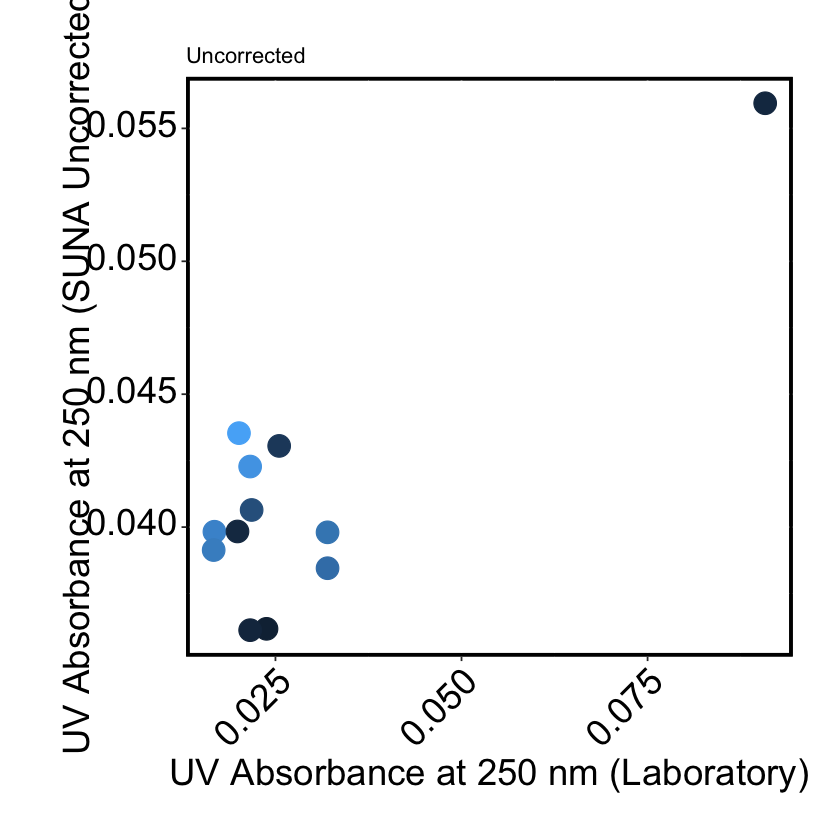

`geom_smooth()` using formula 'y ~ x'



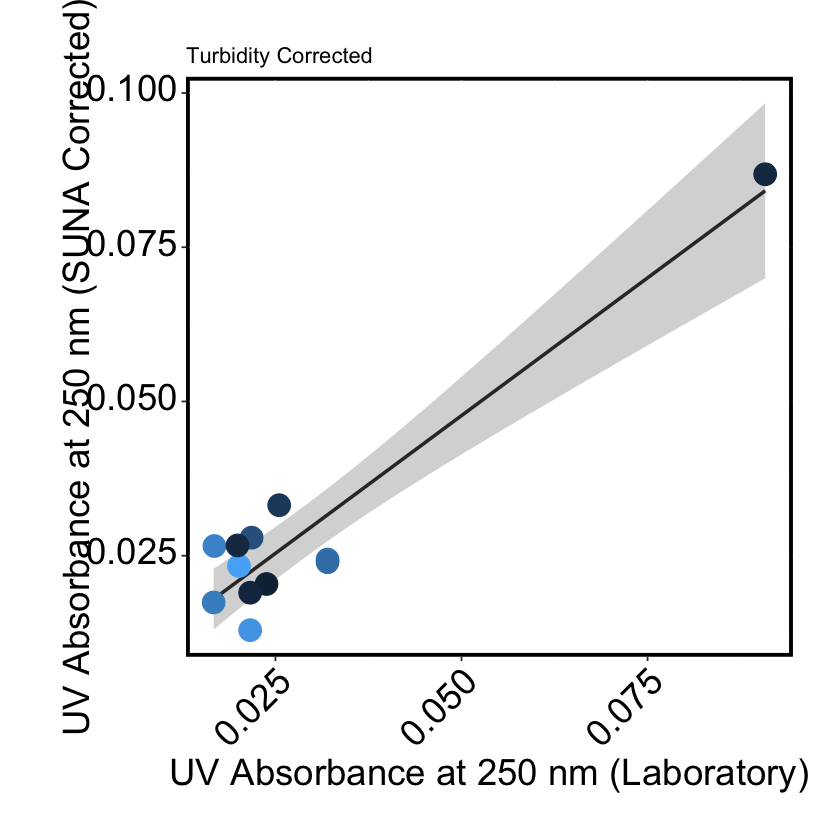

In [17]:
suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)


summary(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))
summary(lm(uva_250_lab~interp_250_c254.mean*turb_log,suna_grab))

suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))


ggplot(suna_grab,aes(uva_250_lab,interp_250_c254.mean,color=pH.mean))+
theme_ts_space+
xlab("UV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Uncorrected)")+
geom_point(size=6)+
ggtitle("Uncorrected")

ggsave("~/neon_suna/plots/COMO_250_uncorrected.pdf",width = 20, height = 20, units = "cm")



ggplot(suna_grab,aes(uva_250_lab,interp_250_tcorr_log,color=pH.mean))+
theme_ts_space+
geom_smooth(method="lm",color="grey20")+
xlab("UV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Corrected)")+
geom_point(size=6)+
ggtitle("Turbidity Corrected")

ggsave("~/neon_suna/plots/COMO_250_corrected.pdf",width = 20, height = 20, units = "cm")




#summary(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c350.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))

In [18]:
names(COMO_sw)

[1] "dtpr"                     "nitrate.mean"            
  [3] "nitrate_mgl.mean"         "a254.mean"               
  [5] "a350.mean"                "sensor_temp.mean"        
  [7] "interp_189.mean"          "interp_190.mean"         
  [9] "interp_191.mean"          "interp_192.mean"         
 [11] "interp_193.mean"          "interp_194.mean"         
 [13] "interp_195.mean"          "interp_196.mean"         
 [15] "interp_197.mean"          "interp_198.mean"         
 [17] "interp_199.mean"          "interp_200.mean"         
 [19] "interp_201.mean"          "interp_202.mean"         
 [21] "interp_203.mean"          "interp_204.mean"         
 [23] "interp_205.mean"          "interp_206.mean"         
 [25] "interp_207.mean"          "interp_208.mean"         
 [27] "interp_209.mean"          "interp_210.mean"         
 [29] "interp_211.mean"          "interp_212.mean"         
 [31] "interp_213.mean"          "interp_214.mean"         
 [33] "interp_215.mean"          "interp_216.mean"         
 [35] "interp_217.mean"          "interp_218.mean"         
 [37] "interp_219.mean"          "interp_220.mean"         
 [39] "interp_221.mean"          "interp_222.mean"         
 [41] "interp_223.mean"          "interp_224.mean"         
 [43] "interp_225.mean"          "interp_226.mean"         
 [45] "interp_227.mean"          "interp_228.mean"         
 [47] "interp_229.mean"          "interp_230.mean"         
 [49] "interp_231.mean"          "interp_232.mean"         
 [51] "interp_233.mean"          "interp_234.mean"         
 [53] "interp_235.mean"          "interp_236.mean"         
 [55] "interp_237.mean"          "interp_238.mean"         
 [57] "interp_239.mean"          "interp_240.mean"         
 [59] "interp_241.mean"          "interp_242.mean"         
 [61] "interp_243.mean"          "interp_244.mean"         
 [63] "interp_245.mean"          "interp_246.mean"         
 [65] "interp_247.mean"          "interp_248.mean"         
 [67] "interp_249.mean"          "interp_250.mean"         
 [69] "interp_251.mean"          "interp_252.mean"         
 [71] "interp_253.mean"          "interp_254.mean"         
 [73] "interp_255.mean"          "interp_256.mean"         
 [75] "interp_257.mean"          "interp_258.mean"         
 [77] "interp_259.mean"          "interp_260.mean"         
 [79] "interp_261.mean"          "interp_262.mean"         
 [81] "interp_263.mean"          "interp_264.mean"         
 [83] "interp_265.mean"          "interp_266.mean"         
 [85] "interp_267.mean"          "interp_268.mean"         
 [87] "interp_269.mean"          "interp_270.mean"         
 [89] "interp_271.mean"          "interp_272.mean"         
 [91] "interp_273.mean"          "interp_274.mean"         
 [93] "interp_275.mean"          "interp_276.mean"         
 [95] "interp_277.mean"          "interp_278.mean"         
 [97] "interp_279.mean"          "interp_280.mean"         
 [99] "interp_281.mean"          "interp_282.mean"         
[101] "interp_283.mean"          "interp_284.mean"         
[103] "interp_285.mean"          "interp_286.mean"         
[105] "interp_287.mean"          "interp_288.mean"         
[107] "interp_289.mean"          "interp_290.mean"         
[109] "interp_291.mean"          "interp_292.mean"         
[111] "interp_293.mean"          "interp_294.mean"         
[113] "interp_295.mean"          "interp_296.mean"         
[115] "interp_297.mean"          "interp_298.mean"         
[117] "interp_299.mean"          "interp_300.mean"         
[119] "interp_301.mean"          "interp_302.mean"         
[121] "interp_303.mean"          "interp_304.mean"         
[123] "interp_305.mean"          "interp_306.mean"         
[125] "interp_307.mean"          "interp_308.mean"         
[127] "interp_309.mean"          "interp_310.mean"         
[129] "interp_311.mean"          "interp_312.mean"         
[131] "interp_313.mean"          "interp_314.mean"         
[133] "interp_315.mean"          "interp_3

# Apply turbidity correction based on lab samples.

In [ ]:
cor_cols<-grep("^interp_",names(COMO_sw))

uva_250_turb_lm<-lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_250_log=log10(COMO_sw[,cor_cols[i]]),turbidity.mean=COMO_sw$turbidity.mean)
	turb_cor_pred<-predict(uva_250_turb_lm,newdata=prepdata)
	COMO_sw[,c(paste(names(COMO_sw)[cor_cols[i]],"_turb",sep=""))]<-turb_cor_pred
}



In [20]:
head(COMO_sw)

,dtpr,nitrate.mean,nitrate_mgl.mean,a254.mean,a350.mean,sensor_temp.mean,interp_189.mean,interp_190.mean,interp_191.mean,interp_192.mean,⋯,interp_390_c350.mean_turb,interp_390_c254.mean_turb,interp_391_c350.mean_turb,interp_391_c254.mean_turb,interp_392_c350.mean_turb,interp_392_c254.mean_turb,interp_393_c350.mean_turb,interp_393_c254.mean_turb,interp_394_c350.mean_turb,interp_394_c254.mean_turb
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-02-01 18:30:00,2.6540,0.037160,0.032975,0.023975,9.355,-0.0286504925,-0.0472699311,-0.018028243,-0.017161725,⋯,0.10250693,0.1474809,0.10250693,0.1474809,0.10250693,0.1474809,0.10250693,0.1474809,0.10250693,0.1474809
2,2019-02-01 18:45:00,2.6180,0.036675,0.039630,0.030235,7.140,-0.0047486919,-0.0053435083,-0.013449097,-0.012439427,⋯,0.10115771,0.1421586,0.10115771,0.1421586,0.10115771,0.1421586,0.10115771,0.1421586,0.10115771,0.1421586
3,2019-02-01 19:00:00,2.5830,0.036165,0.044090,0.033255,6.640,0.0010885231,0.0093221493,-0.020671154,-0.027353030,⋯,0.06182371,0.1270956,0.06182371,0.1270956,0.06182371,0.1270956,0.06182371,0.1270956,0.06182371,0.1270956
4,2019-02-01 19:15:00,2.5310,0.035450,0.047675,0.035920,6.585,0.0008174581,0.0062621334,-0.007263474,-0.008989611,⋯,0.11005728,0.1568844,0.11005728,0.1568844,0.11005728,0.1568844,0.11005728,0.1568844,0.11005728,0.1568844
5,2019-02-01 19:30:00,2.5305,0.035445,0.053615,0.041405,6.680,0.0020776852,-0.0000963057,0.004407766,0.001539665,⋯,0.11695251,0.1583473,0.11695251,0.1583473,0.11695251,0.1583473,0.11695251,0.1583473,0.11695251,0.1583473
6,2019-02-01 19:45:00,2.6160,0.036640,0.054925,0.042105,6.820,-0.0277642061,0.0005293171,0.002741682,-0.032231497,⋯,0.06526743,0.1429749,0.06526743,0.1429749,0.06526743,0.1429749,0.06526743,0.1429749,0.06526743,0.1429749


In [21]:
COMO_swt_0<-COMO_sw[,grep("*_turb$",names(COMO_sw))]
COMO_swt<-bind_cols(COMO_sw[,c("dtpr","nitrate.mean","nitrate_mgl.mean","a254.mean","a350.mean","sensor_temp.mean","specificConductance.mean","dissolvedOxygen.mean","pH.mean","chlorophyll.mean","turbidity.mean","fDOM.mean")],COMO_swt_0)





# Adding PAR data.

In [22]:
COMO_par<-loadByProduct(dpID="DP1.20042.001",site="COMO",check.size=F)
saveRDS(COMO_par,paste(getwd(),"/COMO_par.rds",sep=""))
COMO_par<-readRDS(paste(getwd(),"/COMO_par.rds",sep=""))




Finding available files
  |======================================================================| 100%

  |======================================================================| 100%

Unpacking zip files using 1 cores.
Stacking operation across a single core.
Stacking table PARWS_1min
Stacking table PARWS_5min
Stacking table PARWS_30min
Merged the most recent publication of sensor position files for each site and saved to /stackedFiles
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 3 data tables and 2 metadata tables!
Stacking took 50.08288 secs


In [23]:
#lubridate::round_date(COMO_parts$dtp, "15 minutes")


In [24]:

COMO_parts<-COMO_par$PARWS_5min
COMO_parts$dtp<-COMO_parts$startDateTime
#str(COMO_wqk)



COMO_parts$dtpr<-lubridate::round_date(COMO_parts$dtp, "15 minutes")
COMO_parts_red<-summaryBy(PARMean~dtpr,COMO_parts,FUN=c(mean))
head(COMO_parts_red)
#str(COMO_wq_red)

COMO_swtpar<-merge(COMO_swt,COMO_parts_red,by="dtpr",all.x=TRUE)


,dtpr,PARMean.mean
,<dttm>,<dbl>
1,2016-09-01 00:00:00,NA
2,2016-09-01 00:15:00,NA
3,2016-09-01 00:30:00,NA
4,2016-09-01 00:45:00,NA
5,2016-09-01 01:00:00,NA
6,2016-09-01 01:15:00,NA


In [25]:

str(COMO_swtpar$dtpr)

attr(COMO_swtpar$dtpr,"tzone") <- "Etc/GMT+5"

str(COMO_swtpar$dtpr)
COMO_swtpar$date<-as.Date(COMO_swtpar$dtpr,tz="Etc/GMT+5")

COMO_dates<-unique(COMO_swtpar$date)

for(i in 1:length(COMO_dates)){
    
    
}

 POSIXct[1:24822], format: "2019-02-01 18:30:00" "2019-02-01 18:45:00" "2019-02-01 19:00:00" ...
 POSIXct[1:24822], format: "2019-02-01 13:30:00" "2019-02-01 13:45:00" "2019-02-01 14:00:00" ...


In [26]:

#COMOd<-subset(COMO_swtpar,date==as.Date("2019-06-10"))
COMOd<-COMO_swtpar

COMOdk<-COMOd[,grep("*c254.mean_turb$",names(COMOd))]
COMOdk$dtpr<-COMOd$dtpr

COMOdm<-subset(melt(COMOdk,id.vars=c("dtpr")),!is.na(value))
COMOdm$wavelength<-gsub("interp_","",COMOdm$variable,fixed=TRUE)
COMOdm$wavelength<-as.numeric(gsub("_c254.mean_turb","",COMOdm$wavelength,fixed=TRUE))



str(COMOdm)

'data.frame':	4716901 obs. of  4 variables:
 $ dtpr      : POSIXct, format: "2019-02-01 13:30:00" "2019-02-01 13:45:00" ...
 $ variable  : Factor w/ 206 levels "interp_189_c254.mean_turb",..: 10 10 10 10 10 10 10 10 10 10 ...
 $ value     : num  0.402 0.402 0.396 0.422 0.441 ...
 $ wavelength: num  198 198 198 198 198 198 198 198 198 198 ...


# Trying some ridge plots to look at wavelength changes over time.
So far not looCOMO super great.

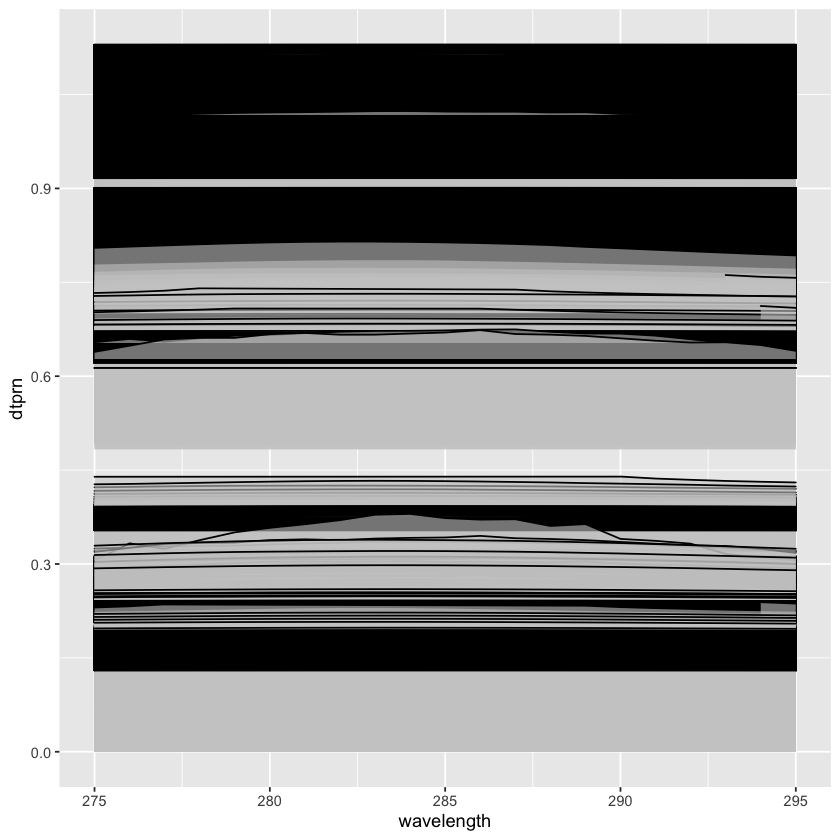

In [27]:
#library(ggridges)
#scales::rescale(height)
#COMOdm$dtprn<-scales::rescale(as.numeric(COMOdm$dtpr))
#COMOdm$abs<-scales::rescale(as.numeric(COMOdm$value))


#ggplot(subset(COMOdm,wavelength>=275&wavelength<=295),aes(x = wavelength, y = dtprn, group=dtprn,height = abs)) +
#  geom_ridgeline(fill="grey80",alpha=0.6)

#ggsave("~/neon_suna/plots/COMOdm_ridge.pdf",width = 20, height = 40, units = "cm")


# Calculating spectral slope 275-295nm on each time step.

In [ ]:
names(COMOd)
names(COMOdm)

In [ ]:
ssm_275_295<-subset(COMOdm,wavelength>=275&wavelength<=295)
dtps<-unique(ssm_275_295$dtpr)
pb <- progress_bar$new(
	format = "  downloading [:bar] :percent eta: :eta",
	total = length(dtps), clear = FALSE, width= 60)
s275295_comp<-data.frame()


for(i in 1:length(dtps)){
	ssm_now<-subset(ssm_275_295,dtpr==dtps[i])
	
	ssm_now$am1<-ssm_now$value*100*2.3025851
	ssm_now$lnam1<-log(ssm_now$am1)


	if(sum(!is.na(ssm_now$lnam1))>2){
		s275295<-lm(ssm_now$lnam1~ssm_now$wavelength)$coefficients[2]*-1
		}else{s275295<-NA}
		s275295_temp<-data.frame(dtpr=dtps[i],s275295=s275295)
		s275295_comp<-bind_rows(s275295_comp,s275295_temp)
#		pb$tick()
}	
	


In [30]:
nrow(s275295_comp)
nrow(COMO_swtpar)
COMO_swtp_ss<-merge(COMO_swtpar,s275295_comp,by="dtpr",all.x=TRUE)
saveRDS(COMO_swtp_ss,paste(data,"COMO_swtp_ss.rds",sep=""))

[1] 24014

[1] 24822

# Extracting spectral daily slope ratio discrepancy.

In [31]:
sdates<-unique(as.Date(COMO_swtp_ss$dtpr,tz="Etc/GMT+5"))

#i<-30
comp_df<-data.frame()
for(i in 1:length(sdates)){
#print(i)
start<-as.POSIXct(paste(sdates[i]-1,"22:00",tz="Etc/GMT+5"))
finish<-as.POSIXct(paste(sdates[i]+1,"03:00",tz="Etc/GMT+5"))
COMOday<-subset(COMO_swtp_ss,dtpr>=start & dtpr<=finish)
COMOday<-subset(COMOday,!is.na(PARMean.mean) & !is.na(s275295))

if(nrow(COMOday)>80){
    COMOday$PAR_roll<-as.numeric(c("NA",rollmean(COMOday$PARMean.mean,k=3,align=c("center"),na.fill=TRUE),"NA"))
    COMOday$s275295_roll<-as.numeric(c("NA",rollmean(COMOday$s275295,k=3,align=c("center"),na.fill=TRUE),"NA"))



    COMO_night<-subset(COMOday,PARMean.mean<200)
    night_s275295<-mean(COMO_night$s275295,na.rm=TRUE)
    
    #COMOday$baseline<-predict(lm(s275295~dtpr,COMO_night),COMOday)
    COMOday$baseline_roll<-predict(lm(s275295_roll~dtpr,COMO_night),COMOday)    
    COMOday$s275295_bs<-COMOday$s275295_roll-COMOday$baseline_roll    
    
    COMO_night_am<-subset(COMO_night,hour(dtpr)<=12)
    night_s275295_am<-mean(COMO_night_am$s275295,na.rm=TRUE)
    
    COMO_night_pm<-subset(COMO_night,hour(dtpr)>12)
    night_s275295_pm<-mean(COMO_night_pm$s275295,na.rm=TRUE)
    
    COMO_day<-subset(COMOday,PARMean.mean>=10)
    day_s275295<-mean(COMO_day$s275295,na.rm=TRUE)

    day_s275295_base_sum<-sum(COMO_day$s275295_bs,na.rm=TRUE)
    day_PAR_roll_base_sum<-sum(COMO_day$PAR_roll,na.rm=TRUE)    

    int<-lm(s275295_bs~PAR_roll,COMO_day)$coef[1]
    slope<-lm(s275295_bs~PAR_roll,COMO_day)$coef[2]    
    
    COMO_n_am_time<-nrow(COMO_night_am)
    COMO_n_pm_time<-nrow(COMO_night_pm)
    COMO_d_time<-nrow(COMO_day)
    
    temp_df<-data.frame(site="COMO",date=sdates[i],night_s275295=night_s275295,night_s275295_am=night_s275295_am,night_s275295_pm=night_s275295_pm,day_s275295=day_s275295,day_s275295_base_sum=day_s275295_base_sum,day_PAR_roll_base_sum=day_PAR_roll_base_sum,int=int,slope=slope,COMO_n_am_time=COMO_n_am_time,COMO_n_pm_time=COMO_n_pm_time,COMO_d_time=COMO_d_time)
    comp_df<-bind_rows(comp_df,temp_df)
    }
}




Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(e

[1]  0.0004472596 -0.0054436262 -0.0019429185 -0.0020735601 -0.0016291092
 [6]  0.0014532301  0.0014991300  0.0045187690 -0.0006546604  0.0011213153
[11]  0.0004753760  0.0001895161  0.0007249980  0.0019595112 -0.0011934378
[16] -0.0004142593 -0.0009997084 -0.0023192370  0.0008874655  0.0017498905
[21]  0.0034263714 -0.0043355795 -0.0016716271 -0.0013689511 -0.0042935605
[26] -0.0019561402 -0.0016354836 -0.0004882862  0.0001925228 -0.0002381915
[31]  0.0015489311  0.0012134258  0.0018853712  0.0013640567  0.0016508497
[36]  0.0018340584

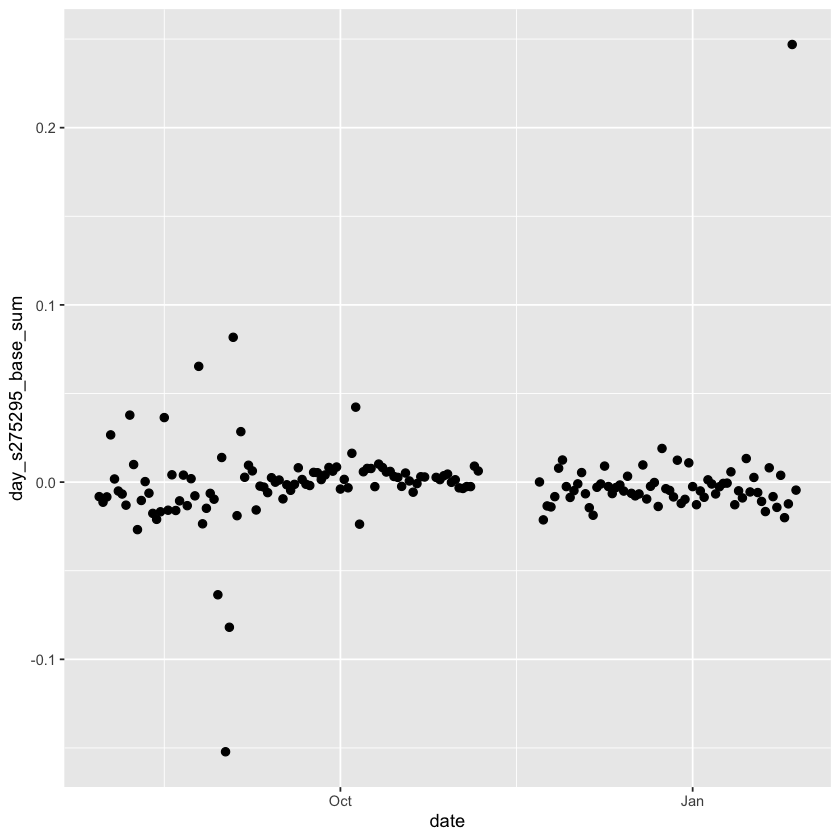

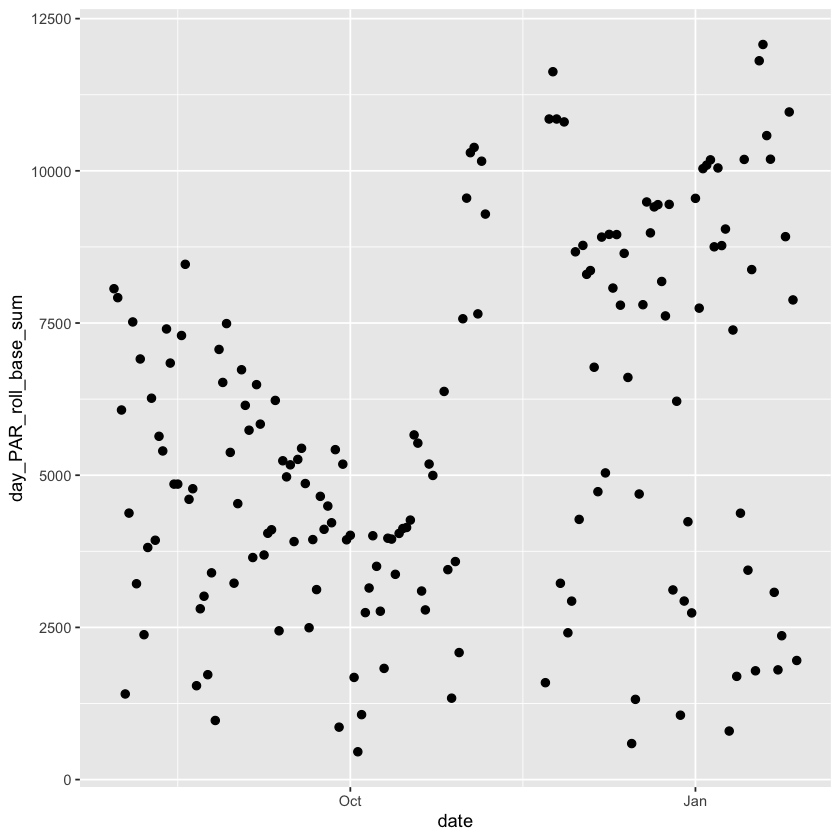

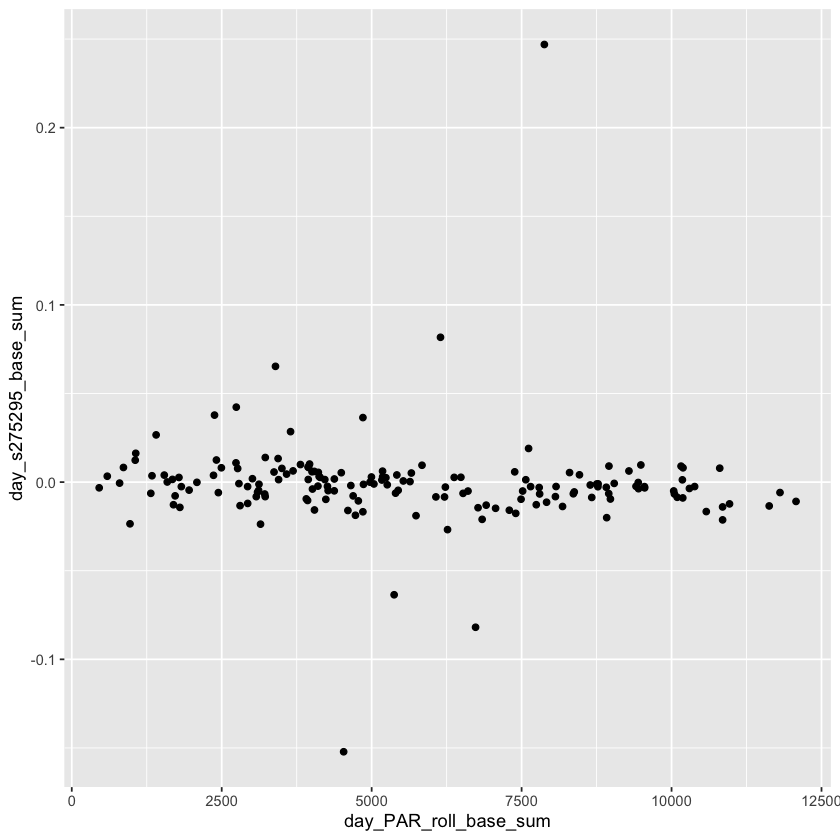

In [32]:
    COMO_day$s275295_bs
ggplot(comp_df,aes(date,day_s275295_base_sum))+
       geom_point(size=2)
ggplot(comp_df,aes(date,day_PAR_roll_base_sum))+
       geom_point(size=2)


ggplot(comp_df,aes(day_PAR_roll_base_sum,day_s275295_base_sum))+
geom_point()


saveRDS(comp_df,paste(data,"comp_df_COMO.rds",sep=""))

[1] 0

 num(0) 


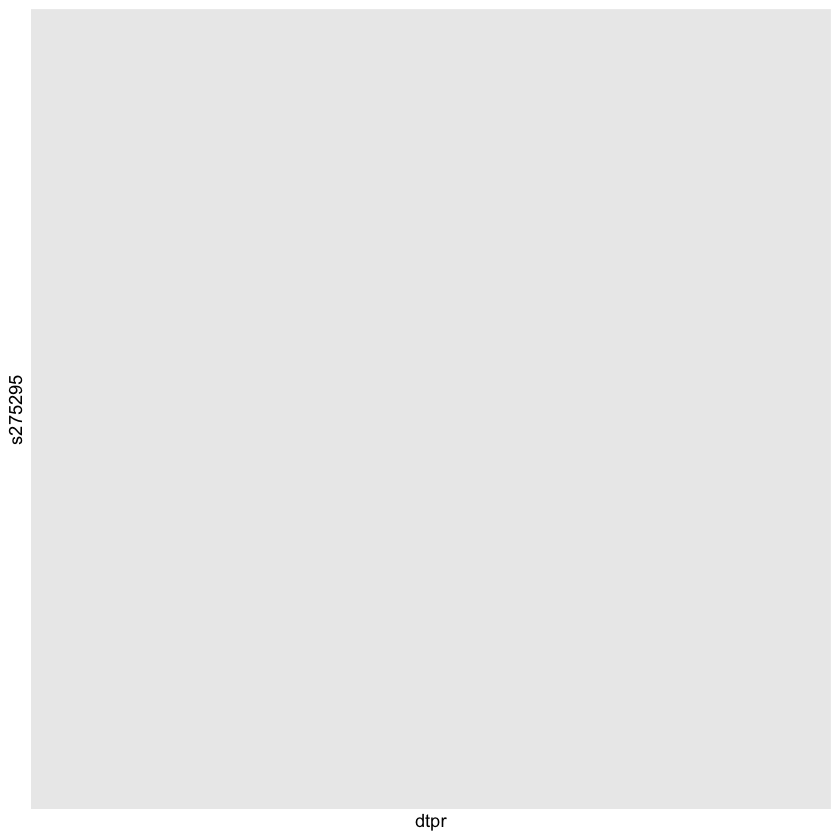

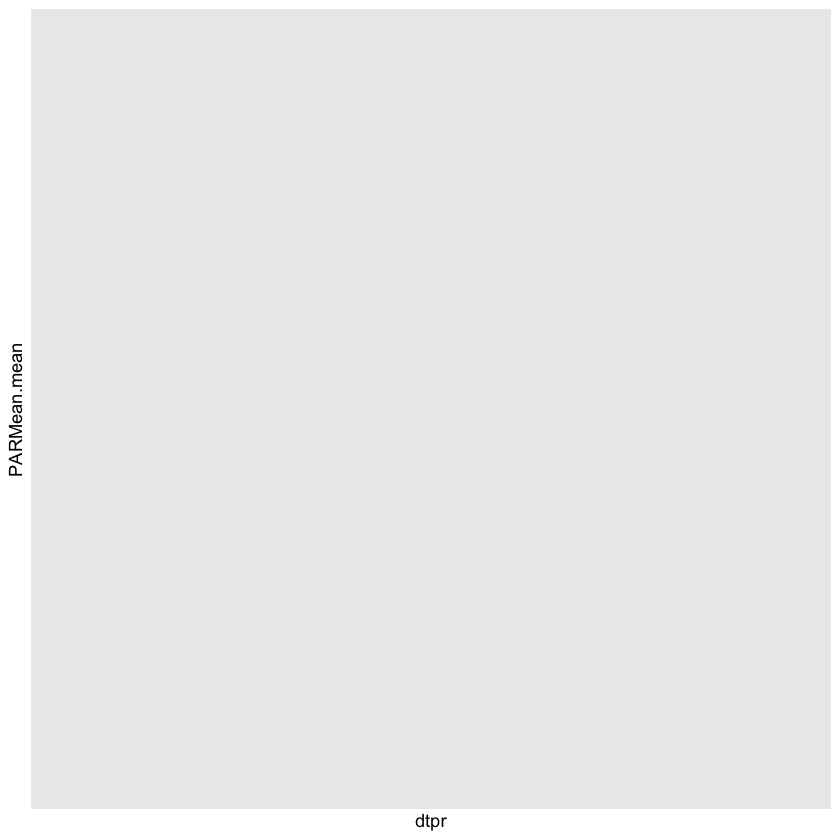

In [33]:
COMOday<-subset(COMO_swtp_ss,as.Date(dtpr,tz="Etc/GMT+5")==as.Date("2019-06-11",tz="Etc/GMT+5"))
nrow(COMOday)

str(COMOday$s275295)



ggplot(COMOday,aes(dtpr,s275295))+
geom_point()


ggplot(COMOday,aes(dtpr,PARMean.mean))+
geom_point()

